## DOMAIN OF THE DATA
<br>
 PPI network can be represented as a graph with a total of $\space n = 56944 \space$ nodes ($\space n_{train} = 44906 \space$ in the training set and $\space n_{test} = 12038 \space$ in the test set) 
 where each node can be identified with a specific protein. 
 Furthermore each node is characterized with a <b>really sparse</b> binary features 
 vector $\space x\in \{0,1\}^{50} \space$ and a fixed number of undirected edges that connect each node to the others. 

In addition to the features we have the labels  of the training set ( a vector $l\in \{0,1\}^{122}$)
and our goal is to predict the labels of the test set with the best accuracy (F1 score will be evaluated). 
These are the data distributions: 

<div>
<img src="./images/Training_set_features.png" height=280 width=280>
<img src="./images/Training_set_feature_elements.png" height=280 width=280>
<img src="./images/test_set_features.png" height=280 width=280>
</div>

<div>
<img src="./images/Test_set_feature_elements.png" height=280 width=280>
<img src="./images/labels.png" height=280 width=280>
<img src="./images/label_component.png" height=280 width=280>
</div>

'Feature10' ( which corresponds to the third element in the plot ) is costant to zero in each sample of the dataset,
we delete it since it cannot explain any causal correlation with the labels. 
Overall, the sparsity of the features tells us that we'll need to extract as much information as we can from graph structure. 
As far as labels are concerned, under the assumption of independence between label classes,
for the Central Limit Theorem we can conclude that the means of the elements belonging to each one of the 122 classes 
will be the same between training and test set. ( this will come in handy at the end )

<br>

In [2]:
import numpy as np
import utils  
from node2vec import Node2Vec  # NODE2VEC EMBEDDINGS 
import classifier as clf  # VERTEX CLASSIFIER
import matplotlib.pyplot as plt  # PLOTTING



<br>

## LOADING THE DATA

<br>
<div>
<font size="3">In the following section we define four foundamental matrices:</font>
<ul>
    <li>$X_{train}\in \{0,1\}^{n_{train}\times49}$</li>
    <br>
    <li>$X_{test}\in \{0,1\}^{n_{test}\times49}$ </li>
    <br>
    <li>$X = \begin{bmatrix}X_{train} \\ X_{test}\end{bmatrix} \in \{0,1\}^{n\times49}$</li>
    <br>
    <li>$L\in \{0,1\}^{n\times122}$ 
 </li>
</ul>
</div>

In [186]:
# LOADING THE DATA
vertices_train, vertices_test = utils.build_vertices()

X_train_df = utils.build_dataframe(vertices_train, "feature")
X_train_df = X_train_df.drop(['feature_10'], axis=1)  # DROP USELESS FEATURE

X_test_df = utils.build_dataframe(vertices_test, "feature")
X_test_df = X_test_df.drop(['feature_10'], axis=1)  # DROP USELESS FEATURE

labels_df = utils.build_dataframe(vertices_train, "label", preserve_int_col_name=True)


# BUILDING NUMPY MATRICES 
X_train = X_train_df.values
X_test = X_test_df.values
X = np.concatenate((X_train, X_test), axis=0)
labels = labels_df.values

<br>
<font size="3">Here we define our graph  $\space G = (V,E)\space$ that represents the PPI network and we explicit all the edges.</font>

<br>
<br>
<div>
<font size="3">Then we build our masks for training and test set : </font>
<ul>
    <li>$idx_{train} =  \begin{pmatrix} 0,1\dots44905 \end{pmatrix} $</li>
    <br>
    <li>$idx_{test} = \begin{pmatrix} 44906,44907\dots56943 \end{pmatrix} $ </li>
    <br>
</ul>
</div>

In [6]:
# MASK FOR TRAIN/TEST
train_idx = range(X_train.shape[0])
test_idx = range(X_train.shape[0],X.shape[0])

# BUILDING THE GRAPH
G = utils.build_graph()
G = G.to_directed()  


<br>

## NODE2VEC


In our first approach we ignore the features matrix $\space X \space$, instead we embed the vertexes with Node2Vec algorithm, using a definition of neighborhood as flexible as possible.

$ Node2Vec(G) \mapsto R^{128} \space$ 

For every source node $u\in V$ , we define $\space N_{s}(u) \subset V\space$  as a network neighborhood of node $u$ generated through a neighborhood sampling strategy $S$
The strategy $S$ of Node2Vec is the following.
Given a source node $\space u\space$, we simulate a random walk of fixed length $\space l\space$. Let $\space c_{i}$ denote the $\space i_{th}\space$ node in the walk, starting with $c_{0} = u\space$. Nodes $\space c_{i} \space$ are generated with the following distribution: $\space P(c_{i} = x \mid c_{i-1}=v)  =   \begin{cases} 
      \frac{\pi_{vx}}{Z} & if \space(v,x) \in E \\
      0 & otherwise
   \end{cases}
$
where $\space \pi_{vx} \space$ is the unnormalized transition probability between nodes $\space v \space$ and $\space x \space$, and $\space Z \space$ is the normalizing constant. 

Consider a random walk that just traversed
edge $(t, v)$ and now resides at node $v$. The walk now needs to decide on the next step so it evaluates the transition probabilities $\pi_{vx}$ on edges $(v, x)$ leading from $v$. We set then the unnormalized transition probability to $\space \pi_{vx} =\alpha_{pq}(t, x)\cdot w_{vx}$, where, $\space \alpha_{pq}(t, x) =  \begin{cases} 
      \frac{1}{p} & if \space d_{tx}=0 \\
       1 & if \space d_{tx}=1 \\
      \frac{1}{q} & if \space d_{tx}=2
   \end{cases}\space
$ and in our graph $\space w = 1 \space$ since the edges are unweighted. 

The use of two parameters $\space p \space$ and $\space q \space$ allowed us to combine in a single path breadth-first sampling and depth-first sampling. In particular the return parameter $\space p \space$  controls the likelihood of immediately revisiting a node in the walk, and the in-out parameters 'q' allowes the search to differentiate between "inward" and "outward"nodes. Here we set $\space p = 1 \space$  and $\space q =5 \space$  biasing the walks close to node $\space t \space$ (BFS) in order to emphasize structural equivalence.
<div align=center>
<img  src="./images/node2vec.jpg" height=280 width=280>
</div>

In [ ]:
# GENERATING WALKS OVER THE GRAPH
node2vec = Node2Vec(G, dimensions=128, walk_length=12, num_walks=10, p=1, q=5) 


<br>

### SKIP-GRAM 

We proceed by applying the Skip-gram model. We seek to optimize the following objective function, which maximizes the log-probability of observing a network neighborhood $\space N_{S}(u)\space$ for a node u conditioned on its feature representation, given by f: 

$$
 \max_{f} \sum_{u \in V} \log P(N_{s}(u)\mid f(u)) $$

In order to make the optimization problem solvable we make two standard assumptions:

• Conditional independence. We factorize the likelihood by assuming that the probability of observing a neighborhood node given the embedding representation of the source node is independent of  any other neighborhood node:

$$ P(N_{s}(u)\mid f(u)) = \prod_{n_{i} \in N_{s}(u)}P(n_{i} \mid f(u)) $$


• Symmetry in feature space. A source node and neighborhood node have a symmetric effect over each other in feature space. Accordingly, we model the conditional likelihood of every source-neighborhood node pair as a softmax unit parametrized by a dot product of their embeddings:

$$P(n_{i} \mid f(u)) = \frac{\exp(\space f(n_{i}) \cdot f(u))}{\sum_{v \in V}\exp(f(v) \cdot f(u)} $$


With the above assumptions, the objective function simplifies to:

$$ \max_{f} \sum_{u \in V}\bigg[-\log Z_{u} + \sum_{n_{i} \in N_{s}(u)}f(n_{i} \cdot f(u)\bigg]$$

which is a simp

In [ ]:
# FITTING THE SKIP-GRAM MODEL
skipgram = node2vec.fit(window=8)


#  SAVING OUR EMBEDDINGS
embedding_n2v = skipgram[skipgram.wv.vocab]   
np.save('./embedding/embedding_n2v.npy', embedding_n2v)  # SAVING AS  A .NPY FILE

SPIEGA CHE CONCATENIAMO FEATURES CON EMBEDDING PER CLASSIFICARE, ACCENNO SULLA TRAIN ACCURACY (?), ACCENNO AL FATTO CHE NEL CLASSIFIER BILANCIAMO I PESI

In [15]:
# X MATRIX FOR CLASSIFICATION
train_embedding_n2v = embedding_n2v[train_idx]  # EXTRACTING TRAINING SET EMBEDDINGS
test_embedding_n2v = embedding_n2v[test_idx]  #  EXTRACTING TEST SET EMBEDDING
X_train_n2v = np.concatenate((X_train, train_embedding_n2v), axis=1)  #  FEATURES + EMBEDDING
X_test_n2v = np.concatenate((X_test, test_embedding_n2v), axis=1)  # FEATURES + EMBEDDINGS


#  TESTING VALIDATION ACCURACY
#clf.validation_accuracy(X_train_n2v, labels)

#  TESTING TRAIN ACCURACY
node2vec_model = clf.fit_model(X_train_n2v, labels)  # RETURNS TRAINED MODEL AND TRAIN ACCURACY


#  MAKING PREDICTIONS
node2vec_pred = node2vec_model.predict_proba(X_test_n2v) > 0.4  # EVALUATING PREDICTIONS
utils.get_results('./results/node2vec_pred.csv',node2vec_pred, X_test_df)  # SAVING RESULTS IN A .CSV FOR KAGGLE



	Hamming accuracy: 0.438
	Accuracy, exact matches: 0.000
	Macro F1 Score: 0.439
	Micro F1 Score: 0.470


COMMENTO SUI RISULTATI OTTENUTI CON NODE2VEC, !!INTRODUZIONE AL PROSSIMO APPROCCIO( GCN ) 
, SBIZZARRISCITI..


In [187]:
import torch
from gcn.model import GCN 
from train  import train_model 


PARAMETRO  LAMDA PER GLI AUTOANELLI , SPIEGA COME VIENE CREATA LA MATRICE ( DAI UN OCCHIO ALLA FUNZIONE IN UTILS.PY ) 


In [188]:
# BUILDING ADJ MATRIX FOR GCN
A = utils.adjacency_matrix_GCN(G, 1)  


# DEFINING OUR PARAMETERS
n_features = X.shape[1]
n_classes = labels.shape[1]
n_hidden = 32  #  NUMBER OF HIDDEN PARAMETERS IN OUR NET


QUI VIENE CREATO E ALLENATO IL MODELLO..MAGARI UN BREVE ACCENNO ALLA STUTTURA ( 2 LAYER, HIDDEN PARAMETERS,DROPOUT)

In [ ]:
# CREATING AND TRAINING OUR MODEL

gcn_model = GCN(n_features, n_hidden, n_classes, dropout=0.5)
embedding_gcn = train_model(gcn_model, X, A, labels, train_idx, epochs=50, lr=0.005, wd=5e-3)


 86%|████████▌ | 43/50 [00:48<00:07,  1.09s/it]

In [11]:
#  EXTRACTING EMBEDDINGS 
train_embedding_gcn = embedding_gcn[train_idx]
test_embedding_gcn = embedding_gcn[test_idx]


#  TESTING TRAIN ACCURACY (SIGMOID TRESHOLD SET AT 0.4 )
gcn_train_pred = torch.sigmoid(train_embedding_gcn).detach().numpy() > 0.4 
utils.get_score(gcn_train_pred, labels)  # HAMMING ACCURACY, F1-MICRO, F1-MACRO

#  SAVING THE EMBEDDING
np.save('./embedding/embedding_gcn.npy', embedding_gcn.detach().numpy())  # .NPY FILE



	Hamming accuracy: 0.710
	Accuracy, exact matches: 0.000


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


	Macro F1 Score: 0.195
	Micro F1 Score: 0.506


COMMENTO SUI RISULTATI OTTENUTI ( TRAINING ACCURACY ) 

In [12]:
#  MAKING OUR PREDICTION
gcn_test_pred = torch.sigmoid(test_embedding_gcn).detach().numpy() > 0.5  # PREDICTIONS ON TEST SET
gcn_test_pred = utils.a_third_law(labels,gcn_test_pred) # 0.475 accuracy
utils.get_results('./results/gcn_pred.csv',gcn_test_pred, X_test_df)  # SAVING RESULTS IN A .CSV 


CONCLUSIONI FINALI SULLA GCN ( ACCURACY PRATICAMENTE UGUALE A NODE2VEC SE NON INFERIORE ) ( LE FEATURE NON SERVONO A NULLA??) 

PASSIAMO AL PROSSIMO APPROCCIO.. SAGE ( SBIZZARRISCITI )

In [13]:
from sage.model import SAGE


STRUTTURA DEL MODELLO UGUALE A GCN ( 2LAYER , HIDDEN PARAMETERS..) SCRIVI QUELLO CHE PREFERISCI..

In [14]:
#  CREATING THE MODEL
edge_list = torch.LongTensor(utils.edge_list_SAGE())  # list of all the edges
sage_model = SAGE(n_features, n_hidden, n_classes, 0.5)


#  TRAINING THE MODEL 
embedding_sage = train_model(sage_model, X, edge_list, labels, train_idx, epochs=25, lr=0.1,wd=5e-3)
sage_train_pred = torch.sigmoid(embedding_sage[train_idx]).detach().numpy() > 0.5# TRESHOLD ON SIGMOID PROBABILITIES
sage_train_pred = utils.a_third_law(labels,sage_test_pred)
utils.get_score(sage_train_pred, labels)  # HAMMING ACCURACY, F1-MICRO, F1-MACRO


#  SAVING THE EMBEDDING
np.save('./embedding/embedding_sage.npy', embedding_sage.detach().numpy())  # .NPY FILE


100%|██████████| 25/25 [04:31<00:00, 10.88s/it]


	Hamming accuracy: 0.306
	Accuracy, exact matches: 0.000
	Macro F1 Score: 0.445
	Micro F1 Score: 0.468


In [24]:
#  MAKING OUR PREDICTION
sage_test_pred = torch.sigmoid(embedding_sage[test_idx]).detach().numpy() > 0.5  # PREDICTIONS ON TEST SET
sage_test_pred = utils.a_third_law(labels,sage_test_pred) # BEST SAGE 0.477
utils.get_results('./results/sage_test_pred.csv',sage_test_pred, X_test_df)  # SAVING RESULTS IN A .CSV 


CONCLUSIONI RAGGIUNTE SU SAGE.. ( NODE2VEC-GCN-SAGE TUTTI CIRCA LA  STESSA ACCURACY CIRCA 0.44/0.45/0.46 SUL TEST ) INIZIAMO A SOSPETTARE QUALCOSA(??) 
PROVIAMO A GIOCARE UN PO CON CONCATENAZIONE DEGLI EMBEDDING E PCA (?)


In [169]:
Y = np.concatenate((embedding_n2v,embedding_sage),axis=1)  # N2V EMBEDDING concatenated SAGE EMBEDDING
clf.validation_accuracy(Y[train_idx],labels)

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=16.7min
[CV] ................................................. , total=17.4min
[CV] ................................................. , total=17.5min
[CV] ................................................. , total=17.6min
[CV] .

[Parallel(n_jobs=32)]: Done   7 out of  10 | elapsed: 17.8min remaining:  7.6min


[CV] ................................................. , total=17.8min
[CV] ................................................. , total=17.8min
[CV] ................................................. , total=17.8min


[Parallel(n_jobs=32)]: Done  10 out of  10 | elapsed: 17.9min finished


Mean crossvalidation Micro-F1: 0.425


RISULTATI UN PO DELUDENTI ( 0.425 DI MICRO ) PER LA CROSS VALIDATION (SAGE+N2V) CI ASPETTAVAMO DI MEGLIO... VALE LO STESSO PER GCN+N2V ( OMETTO PER BREVITA').

PROVIAMO ORA CON UNA PCA SULLA CONCATENAZIONE

In [173]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 64)
Y_pca = pca.fit_transform(Y)  #  250 --> 64
print('Explained variance: ',np.sum(pca.explained_variance_ratio_))  #  GOOD EXPLAINED VARIANCE
clf.validation_accuracy(Y_pca[train_idx],labels)     

Explained variance:  0.9977764
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 4.0min
[CV] ................................................. , total= 4.1min
[CV] ................................................. , total= 4.1min
[CV] .........................................

[Parallel(n_jobs=32)]: Done   7 out of  10 | elapsed:  4.1min remaining:  1.8min


[CV] ................................................. , total= 4.1min
[CV] ................................................. , total= 4.1min
[CV] ................................................. , total= 4.1min


[Parallel(n_jobs=32)]: Done  10 out of  10 | elapsed:  4.2min finished


Mean crossvalidation Micro-F1: 0.427


ALTRO RISULTATO ABBASTANZA DELUDENTE.. PROVA A COMMENTARE TU ( NON C'E' VERSO DI MIGLIORARLA STA ACCURACY )

PASSIAMO ORA ALLA NOSTRA ULTIMA SPERANZA.. GAT ..


In [8]:
from gat.ppi import PPI
from gat.model import GAT
from gat.training import train,test
from torch_geometric.data import DataLoader


In [9]:
#  LOADING DATASETS 
train_dataset = PPI('./gat',split='train')
test_dataset = PPI('./gat',split='test')
valid_dataset = PPI('./gat',split='valid')  #  LET'S KEEP SOME TRAINING SAMPLES FOR VALIDATION..


#  BATCH TRAINING.. 
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

DESCRIZIONE DEL MODELLO GAT USATO DA NOI.. FAI RIFERIMENTO AL PAPER OPPURE AL FILE MODEL.PY IN /GAT

In [12]:
#  BUILDING AND TRAINING OUR MODEL
model = GAT(n_features,n_classes)
for epoch in range(1, 60):
    loss = train(model,train_loader) 
    acc = test(model,valid_loader) 
    print('Epoch: {:02d}, Loss: {:.4f}, Acc: {:.4f}'.format(epoch, loss, acc))

Epoch: 01, Loss: 0.7536, Acc: 0.4226
Epoch: 02, Loss: 0.6801, Acc: 0.3810
Epoch: 03, Loss: 0.6832, Acc: 0.3790
Epoch: 04, Loss: 0.6222, Acc: 0.4400
Epoch: 05, Loss: 0.6156, Acc: 0.4468
Epoch: 06, Loss: 0.6720, Acc: 0.4529
Epoch: 07, Loss: 0.7165, Acc: 0.4633
Epoch: 08, Loss: 0.6544, Acc: 0.4316
Epoch: 09, Loss: 0.6289, Acc: 0.4537
Epoch: 10, Loss: 0.6482, Acc: 0.4421
Epoch: 11, Loss: 0.5713, Acc: 0.4239
Epoch: 12, Loss: 0.6068, Acc: 0.4197
Epoch: 13, Loss: 0.8002, Acc: 0.4168
Epoch: 14, Loss: 0.8466, Acc: 0.4613
Epoch: 15, Loss: 0.6561, Acc: 0.4474
Epoch: 16, Loss: 0.5970, Acc: 0.4179
Epoch: 17, Loss: 0.6979, Acc: 0.4191
Epoch: 18, Loss: 0.7053, Acc: 0.4709
Epoch: 19, Loss: 0.5955, Acc: 0.4533
Epoch: 20, Loss: 0.5896, Acc: 0.4917
Epoch: 21, Loss: 0.6104, Acc: 0.4518
Epoch: 22, Loss: 0.7435, Acc: 0.4291
Epoch: 23, Loss: 0.6718, Acc: 0.5027
Epoch: 24, Loss: 0.5976, Acc: 0.4605
Epoch: 25, Loss: 0.5660, Acc: 0.4668
Epoch: 26, Loss: 0.5587, Acc: 0.4756
Epoch: 27, Loss: 0.5985, Acc: 0.4859
E

In [17]:
#  MAKING PREDICTIONS
model.cpu()
for data in test_loader:    
    out = model(data.x,data.edge_index)
    
pred = out.float().cpu() > 0
pred = utils.a_third_law(labels,pred)

utils.get_results('./results/gat_pred.csv',pred, X_test_df)  # SAVING RESULTS IN A .CSV 

COMMENTIAMO I RISULTATI OTTENUTI.. 0.52  BEST SCORE ( ABBIAMO USATO UN PO DI STATISTICA PER AIUTARCI )


APPROCCIAMO IL METODO STATISTICO.. SPIEGA UN PO LMEAN E COSA ANDIAMO A FARE

In [155]:
lmean = utils.get_lmean(labels)    
lmean = utils.sort_lmean(lmean)  #  DESCENDING ORDER 

SPIEGA L'ALGORITMO.. UN PO DI FORMULE FANNO BENE


In [174]:
A = 0
k = 0
f1_values = np.zeros(lmean.shape[0])
for i in range(lmean.shape[0]):
    k += lmean[i][0]
for s in range(lmean.shape[0]):
    A += lmean[s][0]
    f1 = 2 * A / (k+ntr*(s+1))
    f1_values[s] = f1

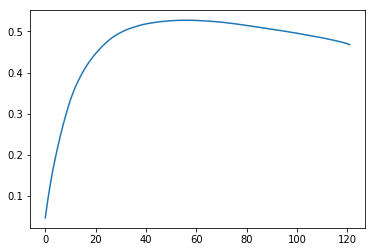

In [185]:
%matplotlib inline
plt.plot(f1_values)



In [ ]:
mask = lmean_f[:np.argmax(f1_values),1]
pred = np.zeros((X_test.shape[0],labels.shape[1]))

for col in range(labels.shape[1]):
    for i in range(np.argmax(f1_values)):
        if(mask[i] == col):
            pred[:,col] =1 
            
utils.get_results('./results/stat.csv',pred, X_test_df)  # SAVING RESULTS IN A .CSV  